In [1]:

import numpy as np

from sklearn.model_selection import train_test_split


from utils import read_jigsaw_data, save_logs, load_logs, save_embeddings, load_embeddings, is_available
from model import get_dense_model
from evaluations import eval_report, mcnemar_test
from plot import plot_perf
from embeddings import get_bert_embeddings
from configs import config as cf

c:\Users\91984\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
data = read_jigsaw_data()

print("Overall toxicity proportion = {0:.2f}%".format(data['target'].mean() * 100))
for i in cf.identity_keys_jigsaw:
    print("\t{} proportion = {:.2f}% | toxicity proportion in {} = {:.2f}%".format(i, data[i].mean()*100, i, data[data[i]]['target'].mean()*100))

Data shape=(6799, 4)
Overall toxicity proportion = 9.93%
	male proportion = 12.18% | toxicity proportion in male = 11.96%
	female proportion = 15.88% | toxicity proportion in female = 11.76%


In [3]:
if is_available(cf.jigsaw_embeddings_path):
    sentence_embeddings = load_embeddings(dataset='jigsaw')
else:
    sentence_embeddings = get_bert_embeddings(data['comment'])
    save_embeddings(sentence_embeddings, dataset='jigsaw')

	Embeddings (shape=(6799, 512)) loaded successfully.


In [4]:
train_df, val_test_df = train_test_split(data, train_size=cf.train_size, random_state=cf.random_state, shuffle=True)
val_df, test_df = train_test_split(val_test_df, train_size=cf.val_test_ratio, random_state=cf.random_state, shuffle=True)

train_labels = np.array(train_df['target']).reshape(-1, 1).astype(float)
val_labels = np.array(val_df['target']).reshape(-1, 1).astype(float)
test_labels = np.array(test_df['target']).reshape(-1, 1).astype(float)

train_groups = np.array(train_df[cf.identity_keys_jigsaw]).astype(int)
val_groups = np.array(val_df[cf.identity_keys_jigsaw]).astype(int)
test_groups = np.array(test_df[cf.identity_keys_jigsaw]).astype(int)

train_relevant_obs_indices = np.where(train_df[cf.identity_keys_jigsaw].sum(axis=1))[0]

train, val_test = train_test_split(sentence_embeddings, train_size=cf.train_size, random_state=cf.random_state, shuffle=True)
val, test = train_test_split(val_test, train_size=cf.val_test_ratio, random_state=cf.random_state, shuffle=True)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Evaluation on test data:
	AUC = 0.9345
	Accuracy = 86.08 %
	Matthews correlation coefficient = 0.5020
		Group-specific MCCs = [0.6189 0.4837]
	f1 score = 0.5267
	Precision = 0.3873
		Group-specific precisions = [0.4516 0.35  ]
	Recall (sensitivity) = 0.8229
		Group-specific recalls = [1.    0.875]
	False negative (miss) rate = 17.7083 %
		Group-specific false negative rates = [ 0.  12.5] %
	False positive (false alarm) rate = 13.5281 %
		Group-specific false positive rates = [15.18 17.45] %
	False negative equality difference (per group) = 0.1146 | total FNED = 0.2292
	False positive equality difference (per group) = 0.0278 | total FPED = 0.0557
	Total equality difference (bias) = 0.2849


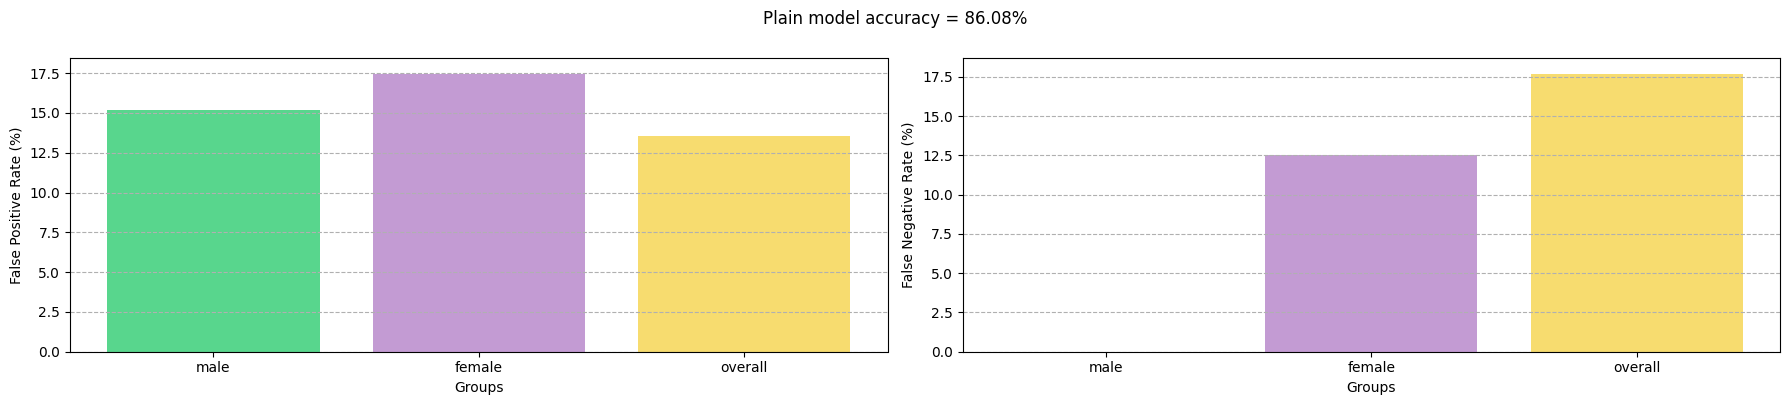

In [5]:
plain_model = get_dense_model()
plain_model.load_weights('{}/{}.h5'.format(cf.MODELS_DIR,cf.jigsaw_plain_model_name))
test_probs_plain = plain_model.predict(test, batch_size=cf.hyperparams['batch_size'])
test_preds_plain = (test_probs_plain > 0.5).astype("int32")
eval_report(test_labels, test_preds_plain, test_probs_plain, test_groups)
plot_perf(test_labels, test_preds_plain, test_groups, cf.identity_keys_jigsaw, 'Plain model')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Evaluation on test data:
	AUC = 0.9321
	Accuracy = 92.65 %
	Matthews correlation coefficient = 0.5708
		Group-specific MCCs = [0.6498 0.608 ]
	f1 score = 0.6114
	Precision = 0.6082
		Group-specific precisions = [0.6667 0.6111]
	Recall (sensitivity) = 0.6146
		Group-specific recalls = [0.7143 0.6875]
	False negative (miss) rate = 38.5417 %
		Group-specific false negative rates = [28.57 31.25] %
	False positive (false alarm) rate = 4.1126 %
		Group-specific false positive rates = [4.46 4.7 ] %
	False negative equality difference (per group) = 0.0863 | total FNED = 0.1726
	False positive equality difference (per group) = 0.0047 | total FPED = 0.0094
	Total equality difference (bias) = 0.1820


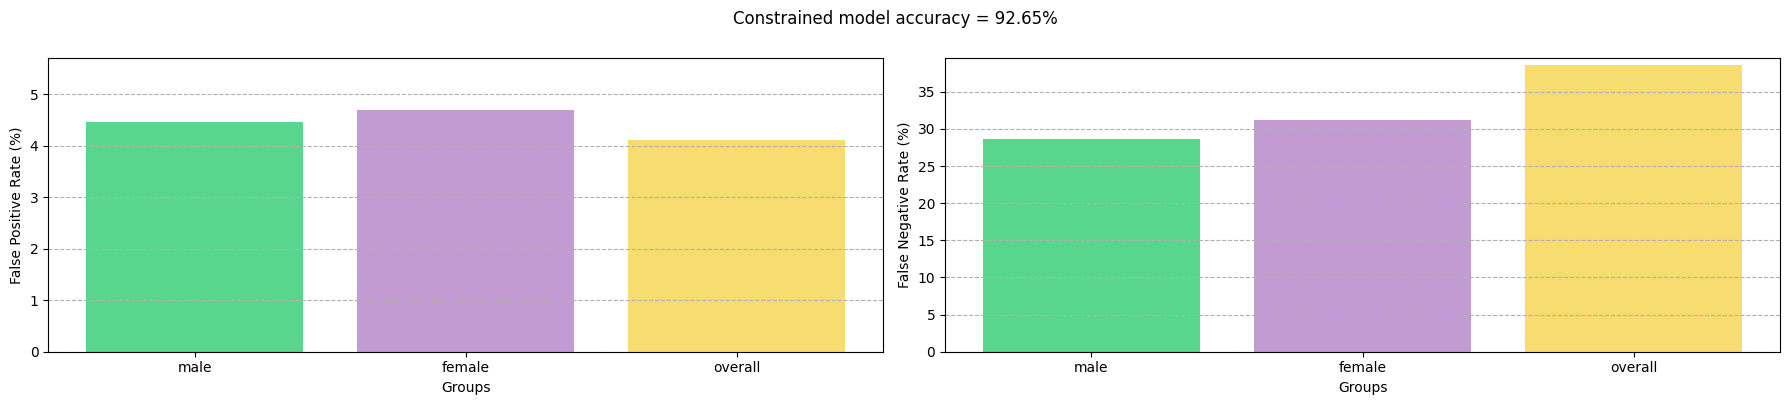

In [6]:
constrained_model = get_dense_model()
constrained_model.load_weights('{}/{}_87.h5'.format(cf.MODELS_DIR, cf.jigsaw_constrained_model_name))

test_probs_const = constrained_model.predict(test, batch_size=cf.hyperparams['batch_size'])
test_preds_const = (test_probs_const>0.5).astype('int32')

eval_report(test_labels, test_preds_const, test_probs_const, test_groups)
plot_perf(test_labels, test_preds_const, test_groups, cf.identity_keys_jigsaw, 'Constrained model')

Evaluation on test data:
	AUC = 0.9321
	Accuracy = 92.65 %
	Matthews correlation coefficient = 0.5708
		Group-specific MCCs = [0.6498 0.608 ]
	f1 score = 0.6114
	Precision = 0.6082
		Group-specific precisions = [0.6667 0.6111]
	Recall (sensitivity) = 0.6146
		Group-specific recalls = [0.7143 0.6875]
	False negative (miss) rate = 38.5417 %
		Group-specific false negative rates = [28.57 31.25] %
	False positive (false alarm) rate = 4.1126 %
		Group-specific false positive rates = [4.46 4.7 ] %
	False negative equality difference (per group) = 0.0863 | total FNED = 0.1726
	False positive equality difference (per group) = 0.0047 | total FPED = 0.0094
	Total equality difference (bias) = 0.1820


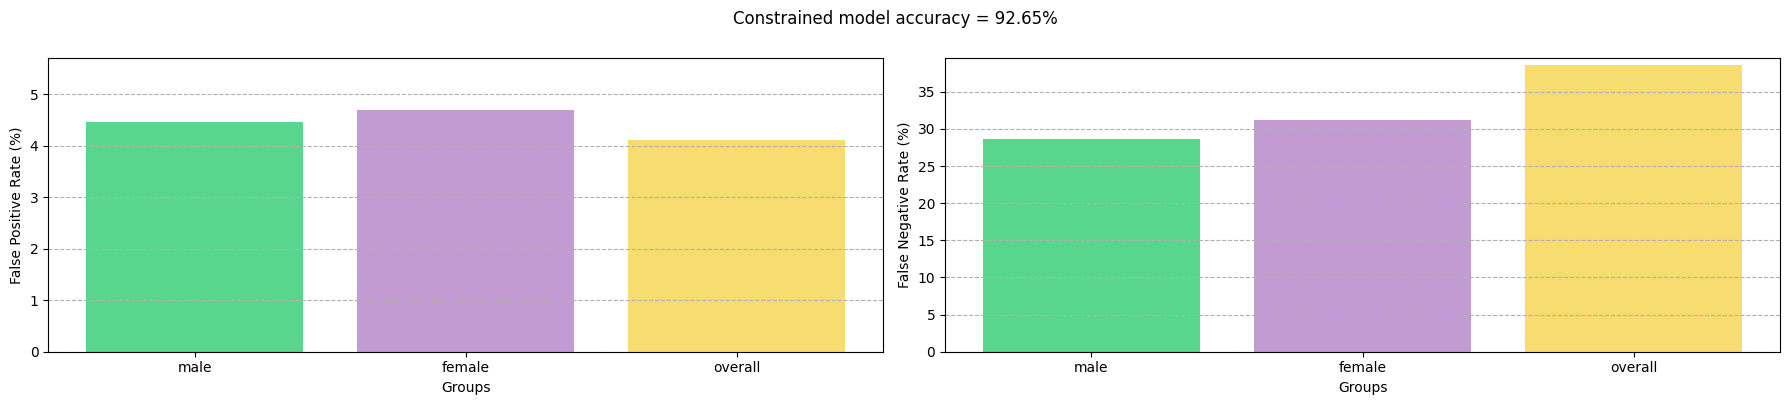

                           Baseline model correct  Baseline model wrong
Constrained model correct                     857                    21
Constrained model wrong                        88                    54

'mlxtend' library implementation
	chi-squared = None
	p-value = 6.112691638091425e-11

'statsmodels' library implementation
pvalue      6.112691638091425e-11
statistic   21.0


In [7]:
eval_report(test_labels, test_preds_const, test_probs_const, test_groups)
plot_perf(test_labels, test_preds_const, test_groups, cf.identity_keys_jigsaw, 'Constrained model')

mcnemar_test(labels=test_labels.ravel(), model1_preds=test_preds_plain.ravel(), model1_name='Baseline model', 
                                         model2_preds=test_preds_const.ravel(), model2_name='Constrained model')